In [73]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data_utils

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np

In [74]:
device = 'mps:0' if torch.backends.mps.is_available() else 'cpu'
print(f'Running on {device}')

Running on mps:0


In [75]:
batch_size = 64

# training + validation dataset
training_set_full = datasets.MNIST('dataset/', train=True, transform=transforms.ToTensor(), download=True)

# test dataset
test_set = datasets.MNIST('dataset/', train=False, transform=transforms.ToTensor(), download=True)

In [76]:
SAMPLE_IMG_ID=0

np.random.seed(42)
shuffled_idx = np.random.choice(len(training_set_full), len(training_set_full), replace=False)
training_set = data_utils.Subset(training_set_full, shuffled_idx[int(len(training_set_full) * 0.1):])
testing_set = data_utils.Subset(test_set, shuffled_idx[int(len(test_set) * 0.1):])

print('Data size after splitting to train / test:')
print(f'Training data: {len(training_set)}, Sample structure: ({type(training_set[SAMPLE_IMG_ID][0])} {training_set[SAMPLE_IMG_ID][0].shape}, {type(training_set[SAMPLE_IMG_ID][1])})')
print(f'Test data: {len(test_set)}, Sample structure: ({type(test_set[SAMPLE_IMG_ID][0])} {test_set[SAMPLE_IMG_ID][0].shape}, {type(test_set[SAMPLE_IMG_ID][1])})')

training_loader = DataLoader(dataset=training_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

Data size after splitting to train / test:
Training data: 54000, Sample structure: (<class 'torch.Tensor'> torch.Size([1, 28, 28]), <class 'int'>)
Test data: 10000, Sample structure: (<class 'torch.Tensor'> torch.Size([1, 28, 28]), <class 'int'>)


In [77]:
IMAGE_SHAPE = training_set_full[0][0].shape[1], training_set_full[0][0].shape[2]
classes = np.unique([t[1] for t in training_set_full])
NUM_CLASSES = len(classes)

class SimpleNeuralNetwork(nn.Module):
    def __init__(self, input_size, classes):
        super().__init__()
        # layer 1
        self.fc1 = nn.Linear(input_size, 50)
        # layer 2
        self.fc2 = nn.Linear(50, classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [78]:
class SimpleNeuralNetwork(nn.Module):
    def __init__(self, input_size, classes):
        super().__init__()
        # layer 1
        self.fc1 = nn.Linear(input_size, 50)
        # layer 2
        self.fc2 = nn.Linear(50, 40)
        self.fc3 = nn.Linear(40,30)
        self.fc4 = nn.Linear(30,20)
        self.fc5 = nn.Linear(20,classes)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        x = self.fc5(x)

        return x


model = SimpleNeuralNetwork(np.product(IMAGE_SHAPE), NUM_CLASSES)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

In [79]:
def evaluate(model, loss_function, X, y):
    # flatten the data from (batch_size, W, H) to (batch_size, W*H) because pytorch models require 1 dimensional samples, and run model.
    predictions = model(X.reshape(X.shape[0], -1))  # Module class implements the __call__ method. that's why this class instance is callable although it's not a function.
                                                    # its __call__ method simply calls our forward() method.
    
    loss = loss_function(predictions, y)
    predictions = predictions.argmax(dim=1).cpu().numpy()
    acc = (predictions == y.cpu().numpy()).mean()
    return predictions, acc, loss

In [80]:
def perturb(data, labels, eta):
    data, labels = data.to(device), labels.to(device)
    data.requires_grad = True

    predictions, acc, loss = evaluate(model, loss_function, data, labels)
    loss.backward()

    res = data.grad
    res = torch.where(res > 0, 1, -1) #sign function

    data = torch.add(data,res * eta)
    return data

In [81]:
PATH = 'path.pth'
torch.save({
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            }, PATH)
ckpt = torch.load(PATH, map_location=device)

In [82]:
ckpt = torch.load('path.pth', map_location=device)

model.load_state_dict(ckpt['state_dict'])
optimizer.load_state_dict(ckpt['optimizer'])

In [83]:
EPOCHS = 7
EVALUATION_FREQ = len(training_set) // batch_size // 10  # guarantee 10 evaluations per epoch

model.to(device)
model.train(mode=True)  # just puts the model in training mode (doesn't actually train)

training_acc_lst, training_loss_lst = [], []
# validation_acc_lst, validation_loss_lst = [], []
epochs_acc = []
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}')
    epoch_acc = []
    training_acc_checkpoint, training_loss_checkpoint = [], []
    for batch_idx, (data, labels) in enumerate(training_loader):
        # cast to device (cpu / gpu) (gpu for faster op). also both need to be on same device.
        data, labels = data.to(device), labels.to(device)
        
        predictions, acc, loss = evaluate(model, loss_function, data, labels)
        training_acc_checkpoint.append(acc)
        epoch_acc.append(acc)

        # loss already calculated in the evaluate() call. just append it
        training_loss_checkpoint.append(loss.item())
        
        # back propagation (calculate the gradient)
        loss.backward()

        # gradient descent (adjust the weights)
        optimizer.step()

        optimizer.zero_grad()  # or model.zero_grad() if all the model's parameters are in the optimizer (in our case they are)

        # evaluate on validation
        if batch_idx % EVALUATION_FREQ == 0:
            # average training acc and loss every EVALUATION_FREQ, so our training and validation plots axes will have the same length
            training_acc_lst.append(np.mean(training_acc_checkpoint))
            training_loss_lst.append(np.mean(training_loss_checkpoint))
            # restart checkpoints
            training_acc_checkpoint, training_loss_checkpoint = [], []
            
            print(f'Training acc: {training_acc_lst[-1]:.2f}, Training loss: {training_loss_lst[-1]:.2f}')

        #     model.train(mode=True)  # re-enter training mode

    # epoch end
    epochs_acc.append(np.mean(epoch_acc))

    if len(epochs_acc) > 1 and epochs_acc[-1] - epochs_acc[-2] < 0.01:
        print(f'{epochs_acc[-1] - epochs_acc[-2]:.2f} accuracy change. Early stopping...')
        break

junk = model.train(mode=False)  # exit training mode

Epoch 1
Training acc: 0.05, Training loss: 2.31
Training acc: 0.12, Training loss: 2.30
Training acc: 0.15, Training loss: 2.25
Training acc: 0.21, Training loss: 2.03
Training acc: 0.21, Training loss: 1.85
Training acc: 0.27, Training loss: 1.78
Training acc: 0.33, Training loss: 1.72
Training acc: 0.39, Training loss: 1.65
Training acc: 0.38, Training loss: 1.58
Training acc: 0.41, Training loss: 1.52
Training acc: 0.46, Training loss: 1.45
Epoch 2
Training acc: 0.66, Training loss: 1.29
Training acc: 0.46, Training loss: 1.40
Training acc: 0.47, Training loss: 1.34
Training acc: 0.51, Training loss: 1.28
Training acc: 0.55, Training loss: 1.20
Training acc: 0.54, Training loss: 1.17
Training acc: 0.62, Training loss: 1.09
Training acc: 0.64, Training loss: 1.04
Training acc: 0.68, Training loss: 0.96
Training acc: 0.70, Training loss: 0.93
Training acc: 0.73, Training loss: 0.88
Epoch 3
Training acc: 0.70, Training loss: 0.87
Training acc: 0.76, Training loss: 0.83
Training acc: 0.

In [90]:
model.train(False)  # ensure we're in eval mode

test_loss = []
test_acc = []
test_predictions = []
test_actuals = []
images_to_print = []
i = 0
for X,y in test_loader:
    X = perturb(X, y, eta=0.007)
    with torch.no_grad():
        X, y = X.to(device), y.to(device)
        predictions = model(X.reshape(X.shape[0], -1))

        loss = loss_function(predictions, y)
        test_loss.append(loss.item())

        if( i < 10 ):
            test_predictions.append(predictions.argmax(dim=1).cpu().numpy()[0])
            test_actuals.append(y[0])
            images_to_print.append(X[0])

        test_acc.append((predictions.argmax(dim=1).cpu().numpy() == y.cpu().numpy()).mean())
    i = i + 1

print(f'Accuracy: {np.mean(test_acc):.2f}, Loss: {np.mean(test_loss):.2f}')

Accuracy: 0.87, Loss: 0.46


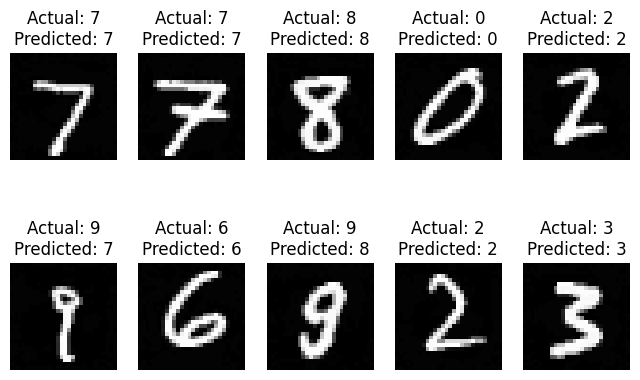

In [91]:
import random

random.seed(42)
show_imgs_idx = np.random.choice(len(testing_set), DRAW_IMGS, replace=False)
DRAW_IMGS = 10
fig = plt.figure(figsize=(8, 5))
fig.tight_layout()
for i, image in enumerate(images_to_print):
    plt.subplot(2, DRAW_IMGS // 2, i+1)
    plt.title(f'Actual: {test_actuals[i]}\nPredicted: {test_predictions[i]}')
    plt.axis('off')
    test_img = image.cpu().detach().numpy()
    plt.imshow(test_img.squeeze(0), cmap='gray')  # "squeeze" removes the first dimension (1,28,28) => (28,28)
     